In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [34]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_set = datasets.Flowers102(root="./flowers102_data", split="train", download=True, transform=transform)
val_set   = datasets.Flowers102(root="./flowers102_data", split="val", download=False, transform=transform)
test_set  = datasets.Flowers102(root="./flowers102_data", split="test", download=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

print(f"Dataset sizes - Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Dataset sizes - Train: 1020, Val: 1020, Test: 6149


In [35]:
class ImprovedEmbeddingNet(nn.Module):
    def __init__(self, base_model='resnet18', embedding_dim=512):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone

        # Slightly stronger embedding head
        self.embedding = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.embedding(features)
        return F.normalize(embeddings, p=2, dim=1)


In [36]:
def get_hard_triplets(embeddings, labels, margin=0.2):
    """Use hardest positive and hardest negative for each anchor"""
    n = embeddings.size(0)
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)

    anchors, positives, negatives = [], [], []

    for i in range(n):
        anchor_label = labels[i]
        pos_mask = (labels == anchor_label) & (torch.arange(n) != i)
        neg_mask = labels != anchor_label

        pos_indices = torch.where(pos_mask)[0]
        neg_indices = torch.where(neg_mask)[0]

        if len(pos_indices) == 0 or len(neg_indices) == 0:
            continue

        pos_dists = pairwise_dist[i, pos_indices]
        neg_dists = pairwise_dist[i, neg_indices]

        hard_pos = pos_indices[pos_dists.argmax()]
        hard_neg = neg_indices[neg_dists.argmin()]

        anchors.append(i)
        positives.append(hard_pos)
        negatives.append(hard_neg)

    if len(anchors) == 0:
        return None, None, None

    return (torch.tensor(anchors, device=embeddings.device),
            torch.tensor(positives, device=embeddings.device),
            torch.tensor(negatives, device=embeddings.device))


In [37]:
def train_triplet(model, train_loader, val_loader, device, epochs=15, margin=0.2):
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.TripletMarginLoss(margin=margin, p=2)

    loss_history = []
    val_acc_history = []

    model.to(device)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            a, p, n = get_hard_triplets(embeddings, labels, margin)

            if a is None:
                continue

            loss = criterion(embeddings[a], embeddings[p], embeddings[n])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        val_acc, _, _ = evaluate_embeddings_knn(model, train_loader, val_loader, device)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Val Acc={val_acc:.2f}%")

        loss_history.append(avg_loss)
        val_acc_history.append(val_acc)

    return loss_history, val_acc_history


In [38]:
def evaluate_embeddings_knn(model, train_loader, test_loader, device, k=1):
    model.eval()
    train_embeddings, train_labels = [], []

    with torch.no_grad():
        for imgs, lbls in tqdm(train_loader, desc="Extracting train embeddings"):
            imgs = imgs.to(device)
            emb = model(imgs).cpu()
            train_embeddings.append(emb)
            train_labels.append(lbls)
    train_embeddings = torch.cat(train_embeddings)
    train_labels = torch.cat(train_labels)

    correct, total = 0, 0
    preds, trues = [], []

    with torch.no_grad():
        for imgs, lbls in tqdm(test_loader, desc="Evaluating KNN"):
            imgs, lbls = imgs.to(device), lbls.to(device)
            test_emb = model(imgs).cpu()
            dists = torch.cdist(test_emb, train_embeddings, p=2)
            _, idxs = dists.topk(k, largest=False)
            knn_labels = train_labels[idxs]
            predictions = torch.mode(knn_labels, dim=1).values
            preds.extend(predictions.numpy())
            trues.extend(lbls.cpu().numpy())
            correct += (predictions == lbls.cpu()).sum().item()
            total += lbls.size(0)

    acc = 100 * correct / total
    return acc, np.array(preds), np.array(trues)


In [39]:
def plot_training_curves(loss_history, val_acc_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(loss_history, marker='o')
    plt.title('Triplet Loss')
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(val_acc_history, marker='s')
    plt.title('Validation Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, num_classes=102):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm[:20,:20], cmap='Blues', annot=False)
    plt.title('Confusion Matrix (First 20 Classes)')
    plt.show()


In [40]:
model = ImprovedEmbeddingNet().to(device)

loss_hist, val_hist = train_triplet(model, train_loader, val_loader, device, epochs=15)

test_acc, y_pred, y_true = evaluate_embeddings_knn(model, train_loader, test_loader, device)
print(f"Final Test Accuracy: {test_acc:.2f}%")

plot_training_curves(loss_hist, val_hist)
plot_confusion_matrix(y_true, y_pred)


Evaluating KNN: 100%|██████████| 16/16 [01:18<00:00,  4.88s/it]


Epoch 1: Loss=0.2373, Val Acc=72.45%


Evaluating KNN:  19%|█▉        | 3/16 [00:25<01:32,  7.11s/it]

Loading best triplet model...
Evaluating with K-Nearest Neighbors...

GENERATING ANALYSIS OUTPUTS

1. Generating training curves...


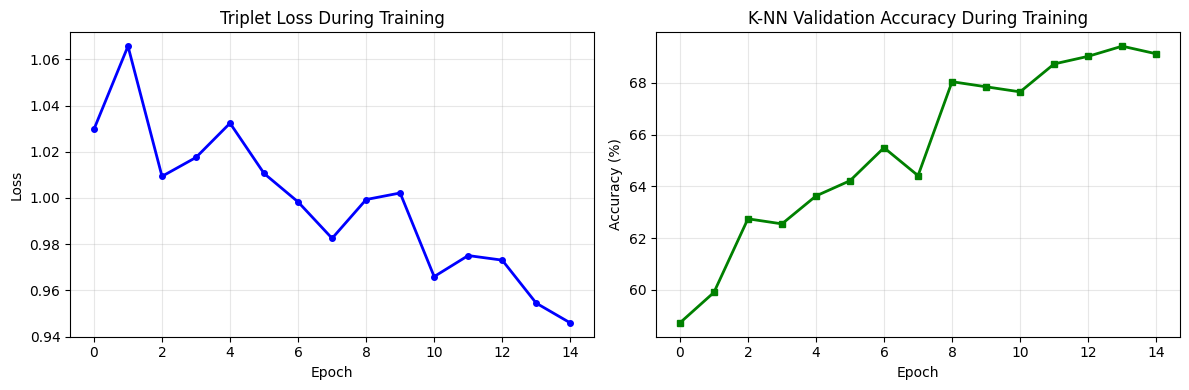

Output: training_curves.png - Generated by plot_training_curves()

2. Generating t-SNE visualization...
Generating t-SNE visualization...


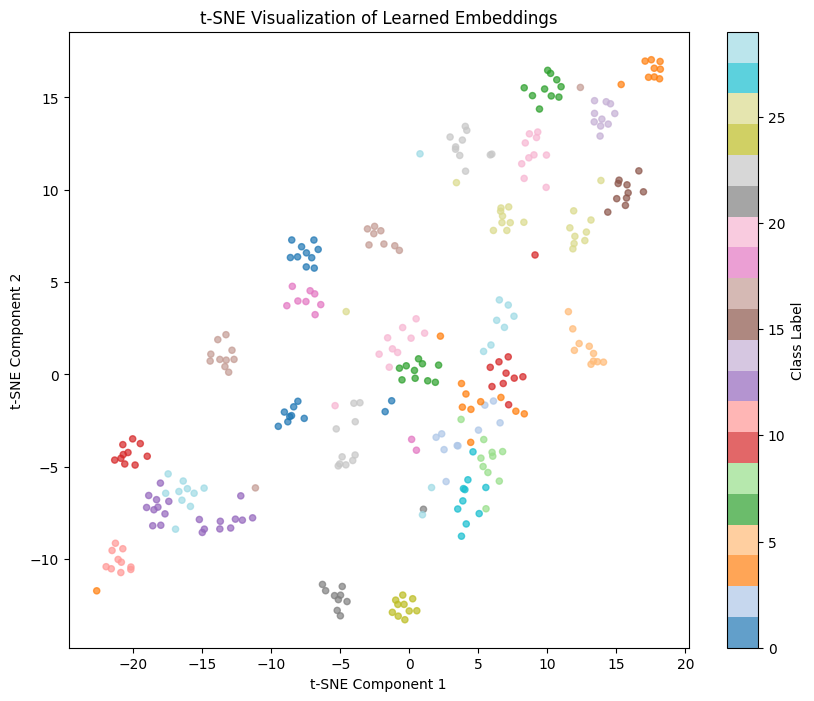

Output: tsne_embeddings.png - Generated by visualize_embeddings()

3. Running K-NN classification...
Extracting training embeddings...


Processing training set: 100%|██████████| 32/32 [01:45<00:00,  3.29s/it]


Classifying test images...


KNN Classification: 100%|██████████| 193/193 [08:23<00:00,  2.61s/it]



K-NN Test Accuracy: 68.55%

4. Generating confusion matrix...


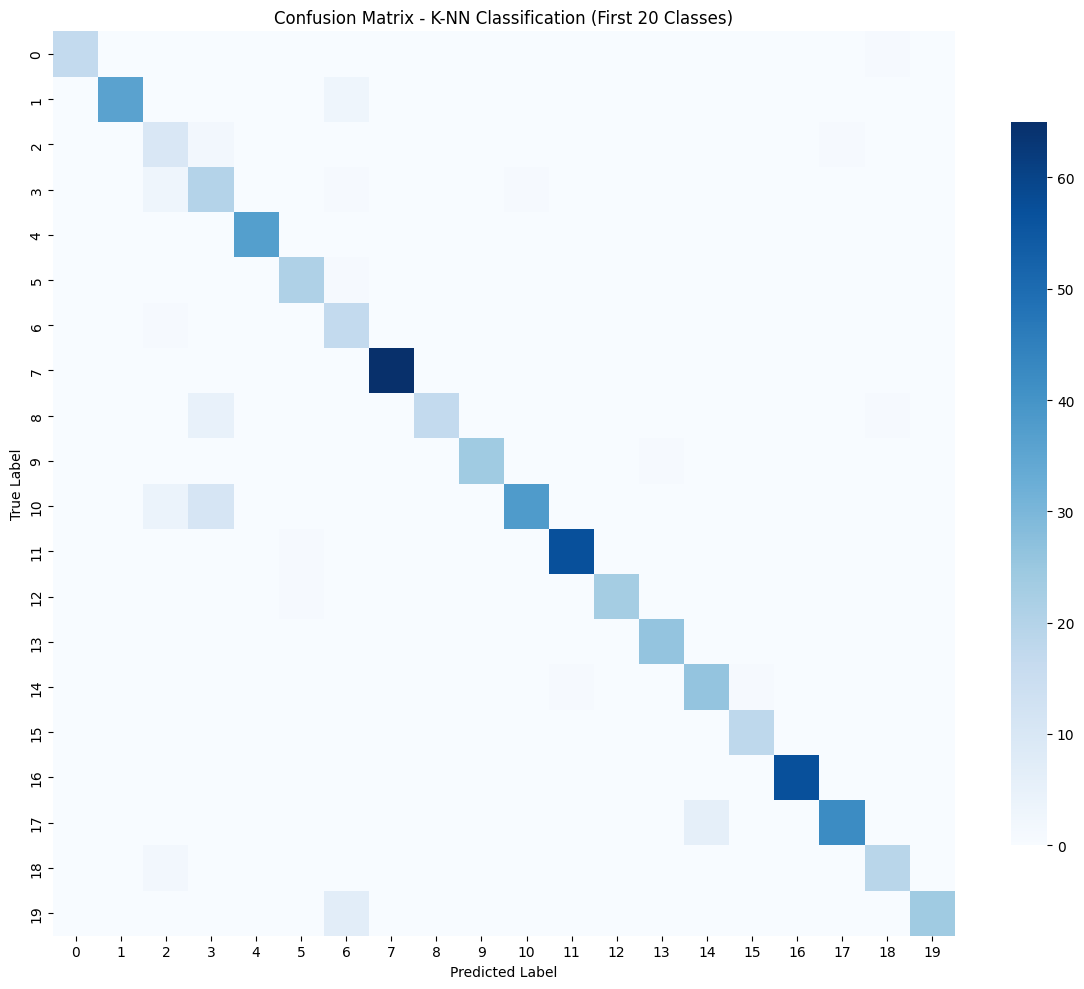

Output: confusion_matrix.png - Generated by plot_confusion_matrix()

5. Calculating per-class accuracy...

Per-class Accuracy Statistics:
Mean: 71.80%
Std: 21.00%
Min: 6.52%
Max: 100.00%
Median: 77.54%

6. Generating similar examples visualization...
Finding similar examples...


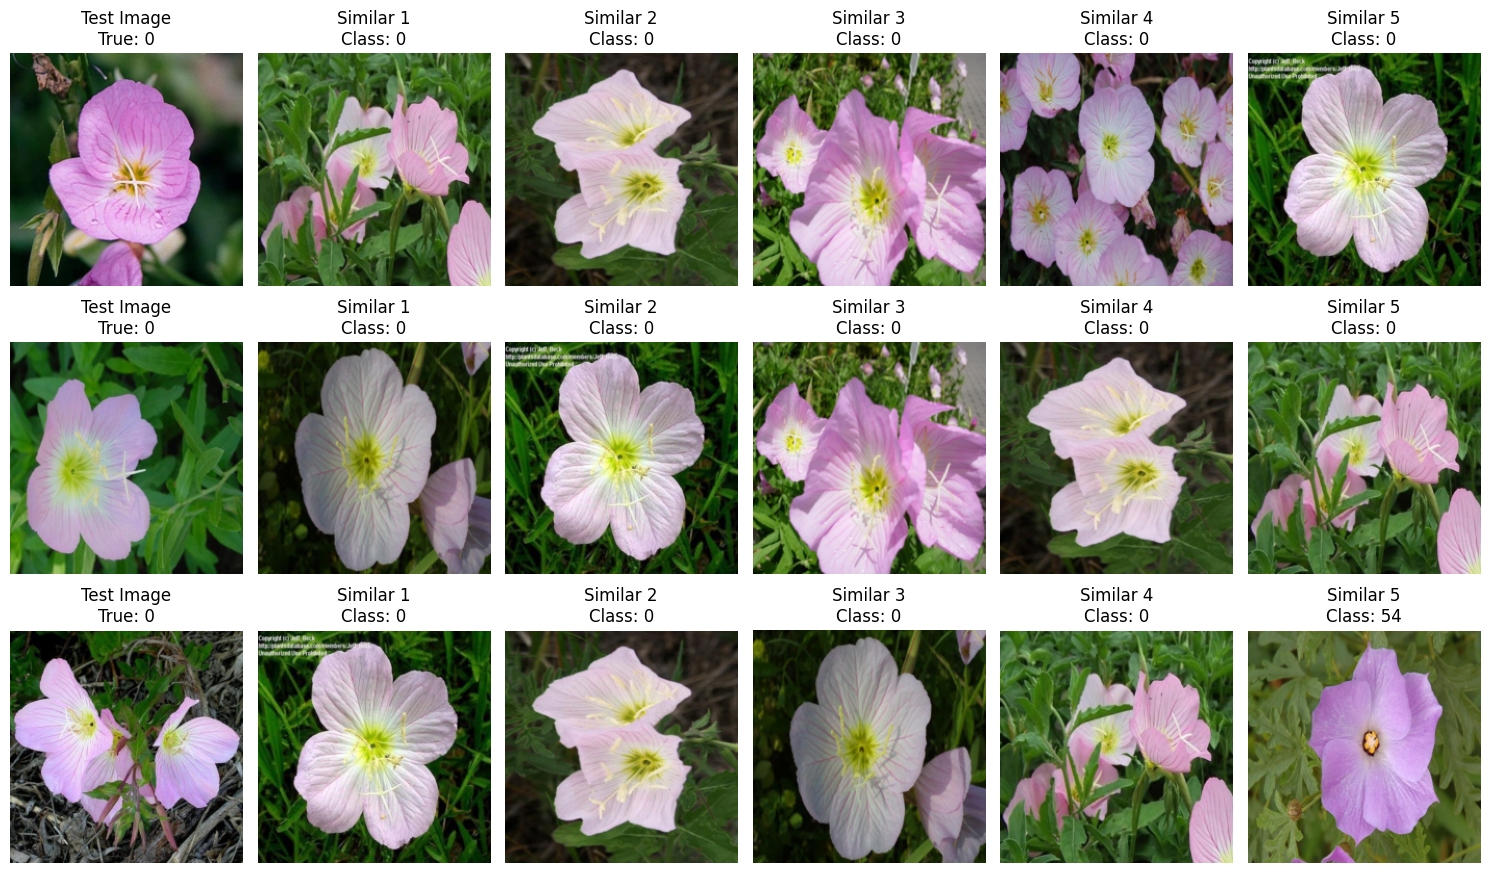

Output: similar_examples.png - Generated by analyze_similar_examples()

7. Generating classification report...

Classification Report (abbreviated):
Overall Accuracy: 68.55%
Macro F1-score: 67.79%

8. Saving numerical results...
Output: training_results.csv - Training history saved


In [22]:
print("Loading best triplet model...")
embedding_model.load_state_dict(torch.load("embedding_model_triplet_best.pth"))

print("Evaluating with K-Nearest Neighbors...")

# Generate all outputs
print("\n" + "="*60)
print("GENERATING ANALYSIS OUTPUTS")
print("="*60)

# Output 1: Training curves
print("\n1. Generating training curves...")
plot_training_curves(loss_history, val_acc_history)

# Output 2: t-SNE visualization
print("\n2. Generating t-SNE visualization...")
embeddings_2d, tsne_labels = visualize_embeddings(embedding_model, val_loader, device, num_samples=300)

# Output 3: K-NN evaluation with predictions
print("\n3. Running K-NN classification...")
test_acc, predictions, true_labels = knn_classification_with_predictions(
    train_loader, test_loader, embedding_model, device, k=5)

print(f"\nK-NN Test Accuracy: {test_acc:.2f}%")

# Output 4: Confusion matrix
print("\n4. Generating confusion matrix...")
cm = plot_confusion_matrix(true_labels, predictions)

# Output 5: Per-class accuracy analysis
print("\n5. Calculating per-class accuracy...")
per_class_acc, acc_stats = generate_per_class_accuracy(true_labels, predictions)

print(f"\nPer-class Accuracy Statistics:")
print(f"Mean: {acc_stats['mean']*100:.2f}%")
print(f"Std: {acc_stats['std']*100:.2f}%")
print(f"Min: {acc_stats['min']*100:.2f}%")
print(f"Max: {acc_stats['max']*100:.2f}%")
print(f"Median: {acc_stats['median']*100:.2f}%")

# Output 6: Similar examples visualization
print("\n6. Generating similar examples visualization...")
analyze_similar_examples(embedding_model, train_loader, test_loader, device, num_examples=3)

# Output 7: Classification report for top classes
print("\n7. Generating classification report...")
class_report = classification_report(true_labels, predictions, output_dict=True, zero_division=0)
print(f"\nClassification Report (abbreviated):")
print(f"Overall Accuracy: {class_report['accuracy']*100:.2f}%")
print(f"Macro F1-score: {class_report['macro avg']['f1-score']*100:.2f}%")

# Output 8: Save numerical results
print("\n8. Saving numerical results...")
results_df = pd.DataFrame({
    'epoch': range(1, len(loss_history) + 1),
    'triplet_loss': loss_history,
    'val_accuracy': val_acc_history
})
results_df.to_csv('training_results.csv', index=False)
print("Output: training_results.csv - Training history saved")